In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import yaml

def parse_cf(cf,lasum):
    ''' logic for parsing each conversion factor entry in the yaml file '''
    if type(cf)==str:
        cf=parse_cfstr(cf,lasum)
    elif type(cf)==list:
        cftot=1
        for f in cf:
            cftot*=parse_cf(f,lasum)
        cf=cftot
    return cf

def parse_cfstr(cf,lasum):
    '''
    replaces the str 1/lasum with the actual number 1/lasum, where lasum is the
    sum of the landarea, typically (ds.area*ds.landfrac).sum(dim=['lat','lon'])
    '''
    if cf=='1/lasum':
        return 1/lasum
    else:
        return float(cf)

def parse_cfs(cfs,lasum):
    '''
    translate the conversion factors inherited from the yaml to a dictionary of
    conversion factors, with two logic rules, lists are returned as the group product,
    and strings are converted to float unless they are special reserved phrases (e.g. '1/lasum')
    '''
    for v in cfs:
        cfs[v]=parse_cf(cfs[v],lasum)
    return cfs                  

def check_freq(tmp):
    ''' infer if the dataset time frequency is monthly or annual '''
    # there has to be a better way to do this
    # is there alreay a function for this?
    # tricky to handle old vs. new clm history files
    nsecs_per_day=24*60*60*1e9
    if 'nbnd' in tmp.time_bounds.dims:
        dt=(tmp.time_bounds.isel(time=-1,nbnd=1)-
            tmp.time_bounds.isel(time=-1,nbnd=0))/nsecs_per_day
    else:
        dt=(tmp.time_bounds.isel(time=-1,hist_interval=1)-
            tmp.time_bounds.isel(time=-1,hist_interval=0))/nsecs_per_day        
    if dt<40:
        freq='monthly'
    else:
        freq='annual'
    return freq

def get_ds(files,freq,dvs):        
    #open dataset and process to an orderly annual dataset
    def pp(ds):
        return ds[dvs]
    if freq=='monthly':
        t=xr.DataArray(xr.date_range('1999',freq='MS',periods=12),dims='time')
        dpm=xr.DataArray(t['time.daysinmonth'].values,dims='time')
        #splitting files up by year
        #too slow to have one big open_mfdataset
        fsets=[files[i:i + 12] for i in range(0, len(files), 12)]
        dsets=[]
        for i,fset in enumerate(fsets):
            ds=xr.open_mfdataset(fset,combine='by_coords',preprocess=pp,
                                 decode_timedelta=False)
            dsets.append((dpm*ds).sum(dim='time')/365)
            ds=xr.concat(dsets,dim='time')
    else:
        ds=xr.open_mfdataset(files,combine='by_coords',preprocess=pp,
                             decode_timedelta=False)
        ds=ds.isel(time=slice(1,len(ds.time)))
    return ds

def plot_drifts(xs,thiscase,ncycles,nyears,units,thresholds,drifts,equils,tpct,la,lasum):
    plt.figure(figsize=[16,12])
    for j,v in enumerate(xs):
        plt.subplot(3,3,j+1)
        if 'gridded' not in v:
            # this is one type of plot, for global variables
            for i in range(ncycles):
                plt.plot(range(nyears),xs[v].isel(time=np.arange(nyears)+i*nyears),label='cycle_'+str(i).zfill(3))
            plt.ylabel(v+' ['+units[v]+']')
            if j==5:
                plt.legend()
            dstr=str(np.round(drifts[v],3))
            tstr='drift='+dstr+units[v]+'/yr'
            gl='><'
            if v in thresholds:
                tstr+=gl[int(equils[v])]
                tstr+=str(thresholds[v])
            else:
                tstr+=' [not evaluated]'
        else:
            # this is an alternative plot for gridded landarea disequilibrium
            x=xs[v]
            if v in thresholds:
                thresh=thresholds[v]
            else:
                thresh=1
            diseq=abs(x-x.shift(time=nyears))/nyears>thresh
            pct=100*(la*diseq).sum(dim=['lat','lon'])/lasum
            ix=np.arange(len(x.time))>=nyears
            pct.where(ix).plot()
            ystr=(r'abs($\Delta$'+v.split('_')[0]+')>'+
                  str(thresh)+units[v]+'/yr'+'\n[% landarea]')
            plt.ylabel(ystr)
            plt.ylim([0,100])
            plt.xlabel('')
            plt.axhline(tpct, ls="--", c="k")
            plt.axvline(xs[v].time.isel(time=ncycles*nyears-1).item(), ls="--", c="k")
            try:
                plt.xlim(xs[v].time.isel(time=0).item(), xs[v].time.isel(time=(ncycles+1)*nyears).item())
            except:
                plt.xlim(xs[v].time.isel(time=0).item(), None)
            dstr=str(np.round(drifts[v],1))
            tstr=dstr+'%'
            gl='><'
            if v in equils:
                tstr+=gl[int(equils[v])]
                tstr+=str(tpct)
            else:
                tstr+=' [not evaluated]'
        if v in equils:
            if not equils[v]:
                tstr='FAILED: '+tstr

        plt.title(tstr)
    plt.suptitle(f"cycle {ncycles} (year {ncycles*nyears})")
    plt.subplots_adjust(hspace=0.2,wspace=0.3)
    plt.show()
    # plt.savefig(thiscase+'.png',dpi=300,bbox_inches='tight')

In [13]:
def calc_cycle_stability(cfile, thresholds, pct_landarea, to_plot=False):
    config = yaml.safe_load(open(cfile))
    thiscase = config['case']
    d = config['hist_dir']
    files = sorted(glob.glob(d+'/*.h0.*'))
    if len(files) < 1:
        failed = True
        print('no files found')
        print('matchstr: '+d+'/*.h0.*')
    else:
        #import config and parse conversion factors
        tmp = xr.open_dataset(files[0],decode_timedelta=True)
        la = tmp.area*tmp.landfrac
        lasum = la.sum().values
        # thresholds=config['thresholds']
        units=config['units']
        cfs=parse_cfs(config['cfs'],lasum)    

        freq=check_freq(tmp)
        dvs=config['data_vars']
        ds=get_ds(files,freq,dvs)

        #set up year variables
        nyears=config['cycle_years']  #years per met forcing cycle
        ncycles=int(len(ds.time)/nyears)

        for ncyc in range(2, ncycles+1):

            y2=nyears*ncyc
            y1=y2-nyears
            y0=y1-nyears

            #abbrev dict
            stocks={'TLAI':'TLAI',
                    'TEC':'TOTECOSYSC',
                    'TSC':'TOTSOMC',
                    'TVC':'TOTVEGC'}
            
            #evaluate global drifts
            drifts={}
            xs={}
            for v in cfs:
                cf=cfs[v]
                if 'gridded' in v:
                    vlong=stocks[v.split('_')[0]]
                    x=cf*ds[vlong]
                else:
                    x=cf*(la*ds[v]).sum(dim=['lat','lon'])
                xs[v]=x
                drift=abs(x.isel(time=slice(y1,y2)).mean(dim='time')-
                            x.isel(time=slice(y0,y1)).mean(dim='time'))/nyears                
                if 'gridded' in v:
                    if v in thresholds:
                        thresh=thresholds[v]
                    else:
                        thresh=1
                    pct=(100*(la*(drift>thresh)).sum(dim=['lat','lon'])/lasum).values
                    drifts[v]=pct
                else:
                    drifts[v]=drift.values

            equils={}
            for v in thresholds:
                if 'gridded' in v:
                    equils[v]=drifts[v]<pct_landarea
                else:
                    equils[v]=drifts[v]<thresholds[v]

            print(f"\ncycle {ncyc} (year {ncyc*nyears})")

            failed=False
            fails=[]
            for v in equils:
                if 'gridded' in v:
                    print(v,drifts[v],pct_landarea,equils[v])
                else:
                    print(v,drifts[v],thresholds[v],equils[v])
                if ~equils[v]:
                    failed=True
                    fails.append(v)

            if 'pct_landarea' in config:
                pct=pct_landarea;
            else:
                pct=np.nan

            if failed:
                print(("** Not in equilibrium **"))
            else:
                print(("!! Reached equilibrium !!"))
                if to_plot:
                    plot_drifts(xs,thiscase,ncyc,nyears,units,thresholds,drifts,equils,
                                pct,la,lasum)
                break

In [14]:
thresholds = {
    "TLAI_gridded": 0.002,
    "TOTECOSYSC": 0.4,
    "TOTVEGC": 0.1,
    "GPP": 0.1,
}
pct_landarea = 3.5


cycle 2 (year 40)
TLAI_gridded 51.110806 3.5 False
TOTECOSYSC 1.3062531 0.4 False
TOTVEGC 0.45580673 0.1 False
GPP 0.12927628 0.1 False
** Not in equilibrium **

cycle 3 (year 60)
TLAI_gridded 28.890738 3.5 False
TOTECOSYSC 0.41633454 0.4 False
TOTVEGC 0.15631028 0.1 False
GPP 0.062913515 0.1 True
** Not in equilibrium **

cycle 4 (year 80)
TLAI_gridded 15.342501 3.5 False
TOTECOSYSC 0.18183441 0.4 True
TOTVEGC 0.07220383 0.1 True
GPP 0.025894165 0.1 True
** Not in equilibrium **

cycle 5 (year 100)
TLAI_gridded 8.470428 3.5 False
TOTECOSYSC 0.088537596 0.4 True
TOTVEGC 0.03385086 0.1 True
GPP 0.013374329 0.1 True
** Not in equilibrium **

cycle 6 (year 120)
TLAI_gridded 4.4896855 3.5 False
TOTECOSYSC 0.04800415 0.4 True
TOTVEGC 0.017169189 0.1 True
GPP 0.0064647673 0.1 True
** Not in equilibrium **

cycle 7 (year 140)
TLAI_gridded 2.2600782 3.5 True
TOTECOSYSC 0.02776947 0.4 True
TOTVEGC 0.008239746 0.1 True
GPP 0.004373169 0.1 True
!! Reached equilibrium !!


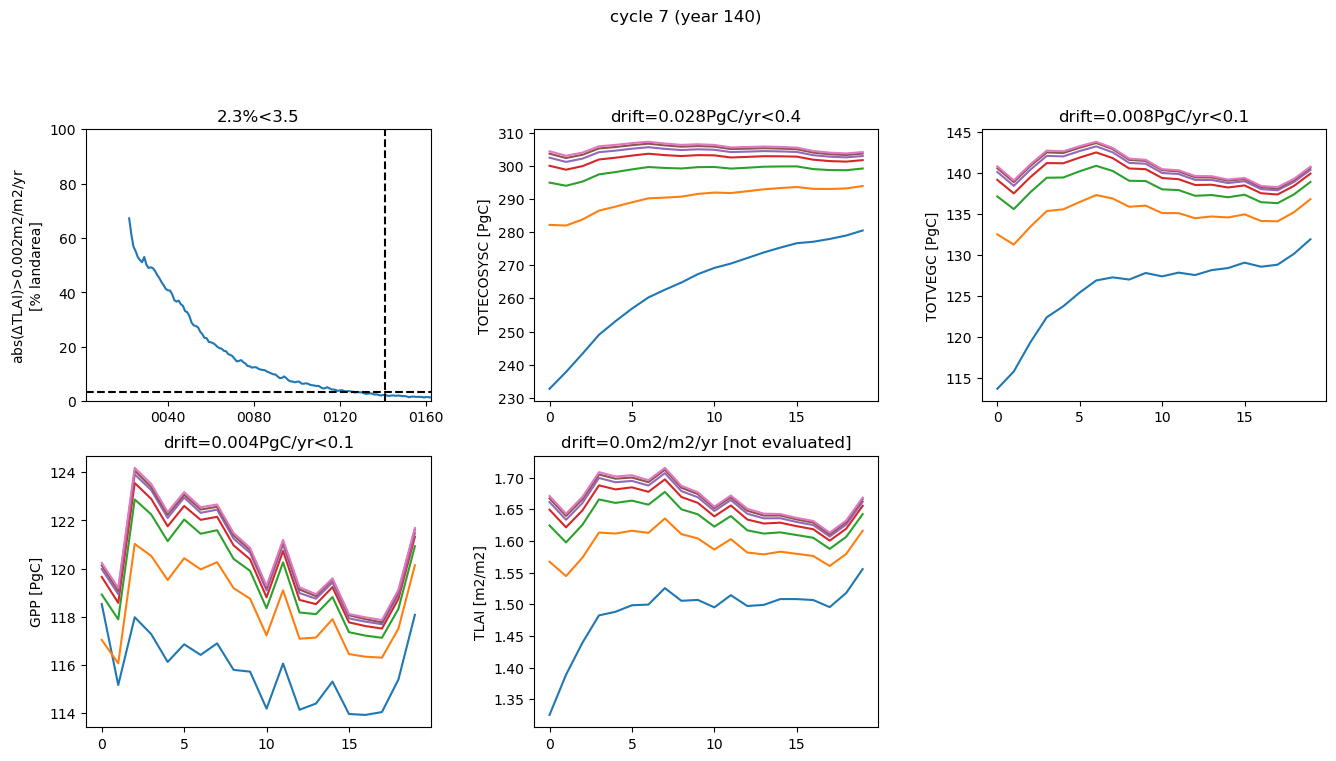

In [15]:
cfile = "AD.yml"
calc_cycle_stability(cfile, thresholds, pct_landarea, to_plot=True)


cycle 2 (year 40)
TLAI_gridded 6.1805944 3.5 False
TOTECOSYSC 0.19833985 0.4 True
TOTVEGC 0.02796631 0.1 True
GPP 0.002254486 0.1 True
** Not in equilibrium **

cycle 3 (year 60)
TLAI_gridded 2.321519 3.5 True
TOTECOSYSC 0.08198242 0.4 True
TOTVEGC 0.012963867 0.1 True
GPP 0.0010261536 0.1 True
!! Reached equilibrium !!


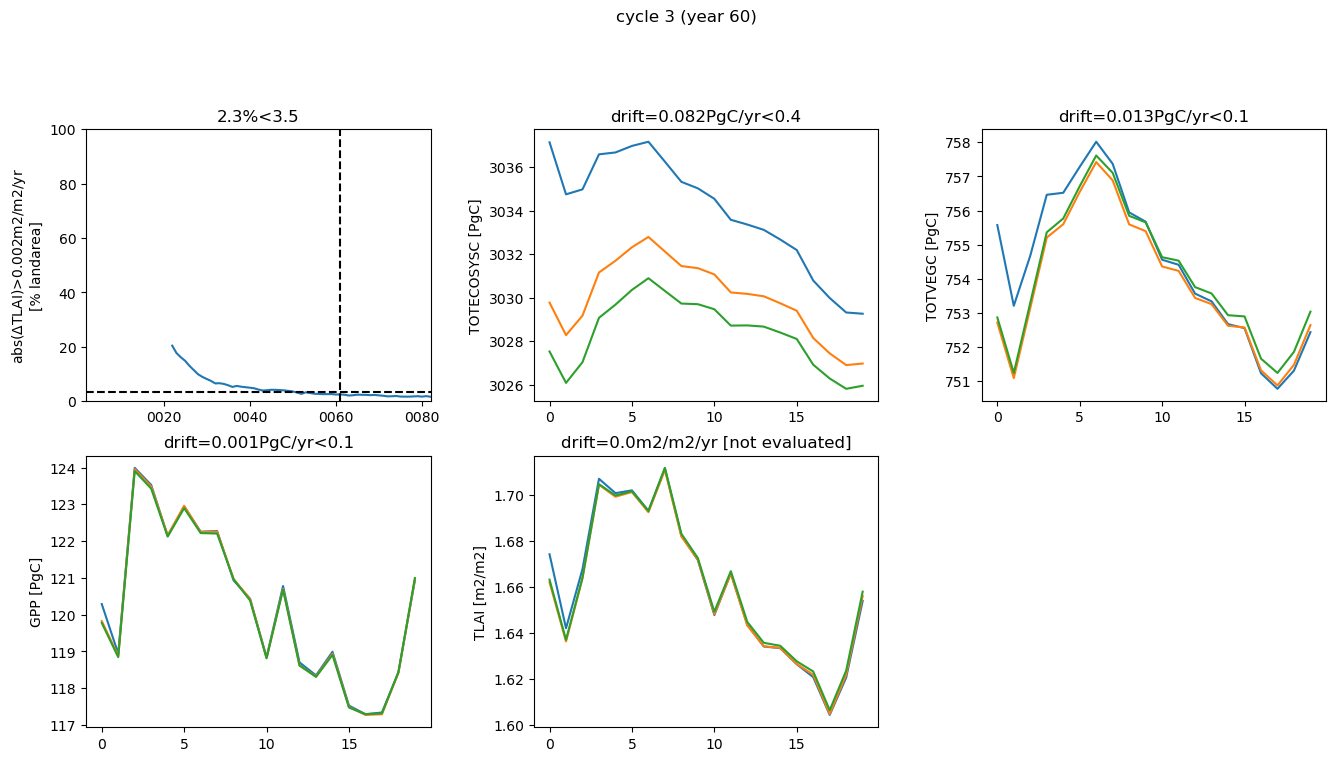

In [16]:
cfile = "PAD.yml"
calc_cycle_stability(cfile, thresholds, pct_landarea, to_plot=True)